# Análise de Marcha
**Bruno da Silva Cunha**

Universidade Federal do Espírio Santo

**3. Análise de Modelos**

Este notebook monta um pipeline completo para classificar a marcha como **normal** ou **anormal** a partir de **poses** extraídas de vídeos.  
Ele usa o CSV de metadados e uma pasta com arquivos **.npy** contendo as sequências de keypoints por vídeo.

**Resumo do que está incluso:**
- Conexão com o **Google Drive**
- Carregamento do CSV e das **poses**
- Criação automática do **rótulo binário**: `normal` (exercise, normal, style) vs `anormal` (demais)
- Extração de **features temporais e normalizadas por escala corporal**
- **GridSearchCV** com **Stratified K-Fold**
- **Normalização** (StandardScaler) dentro dos pipelines
- **Gráficos**: ROC, PR, Matriz de Confusão e Curva de Calibração
- **Salvamento** do melhor modelo (.joblib) no Drive

> ⚠️ Pré-requisito: cada vídeo precisa ter um arquivo de poses `*_poses.npy` compatível (formato `[T, 17, 3]` no padrão COCO/YOLO: 17 pontos com (x, y, conf)).


In [22]:
# === Monta Google Drive ===
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# === Imports essenciais ===
import os, sys, math, json, gc, pathlib, itertools, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, f1_score, accuracy_score
)
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve

import joblib
warnings.filterwarnings('ignore')

# === Caminhos informados pelo usuário ===
CSV_PATH = '/content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/processed_videos_data_v2.csv'
POSES_DIR = '/content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/processed/poses'

CSV_PATH, POSES_DIR


Mounted at /content/drive


('/content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/data/processed_videos_data_v2.csv',
 '/content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/processed/poses')

In [23]:
# === Carrega CSV (robusto a nomes de colunas) ===
df = pd.read_csv(CSV_PATH)

df = df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)


print('Colunas do CSV:', list(df.columns))
print('Amostras:', len(df))

# Tentativa de deduzir a coluna de ID do vídeo
possible_id_cols = ['id', 'video_id', 'vid_id', 'filename', 'name']
id_col = None
for c in possible_id_cols:
    if c in df.columns:
        id_col = c
        break

if id_col is None:
    raise ValueError(f'Não encontrei coluna de ID nas opções {possible_id_cols}. '
                     'Ajuste a variável `id_col` abaixo para o nome correto.')

print('Coluna de ID usada:', id_col)

# A coluna com o tipo (dataset) para mapear normal/anormal
dataset_col = 'dataset'
if dataset_col not in df.columns:
    raise ValueError('CSV não possui a coluna "dataset". Ajuste o nome na variável `dataset_col`.')

df.head(3)


Colunas do CSV: ['seq', 'frame_num', 'cam_view', 'dataset', 'gait_pat', 'id', 'url', 'min_frame', 'max_frame', 'get_info_success', 'fps', 'start_time', 'end_time', 'download_video_success', 'video_path', 'crop_path', 'multi_person', 'poses_path']
Amostras: 37
Coluna de ID usada: id


,seq,frame_num,cam_view,dataset,gait_pat,id,url,min_frame,max_frame,get_info_success,fps,start_time,end_time,download_video_success,video_path,crop_path,multi_person,poses_path
0,cljvx44jt003v3n6lgox22f0q,3920,left side,Abnormal Gait,abnormal,AWS_zIFfGTg,https://www.youtube.com/watch?v=AWS_zIFfGTg,3920,4057,True,24.0,163.333,169.042,True,/content/drive/MyDrive/Estudos/IA_CD/Modelo_Tr...,/content/drive/MyDrive/Estudos/IA_CD/Modelo_Tr...,False,NaN
1,cljw65m0800333n6lpxsiegdj,2745,left side,Abnormal Gait,parkinsons,bmi1hYOnTHs,https://www.youtube.com/watch?v=bmi1hYOnTHs,2745,3233,True,24.0,114.375,134.708,True,/content/drive/MyDrive/Estudos/IA_CD/Modelo_Tr...,/content/drive/MyDrive/Estudos/IA_CD/Modelo_Tr...,False,NaN
2,cljw6n7mg00173n6lnk3lmru5,14,right side,Abnormal Gait,exercise,cAETIJSUobY,https://www.youtube.com/watch?v=cAETIJSUobY,14,228,True,30.0,0.467,7.600,True,/content/drive/MyDrive/Estudos/IA_CD/Modelo_Tr...,/content/drive/MyDrive/Estudos/IA_CD/Modelo_Tr...,False,NaN


In [24]:
df.groupby(dataset_col).size()

,0
dataset,
Abnormal Gait,19
Normal Gait,18


In [25]:
# === Mapeia dataset -> rótulo binário ===
NORMAL_SET = {'normal gait'}

def map_label(x: str) -> str:
    try:
        x_low = str(x).strip().lower()
    except Exception:
        x_low = str(x).lower()
    return 'normal' if x_low in NORMAL_SET else 'anormal'

df['label_bin'] = df[dataset_col].apply(map_label)
print(df['label_bin'].value_counts())

# Codifica y binário
le = LabelEncoder()
y_all = le.fit_transform(df['label_bin'])  # anormal=0, normal=1 (ordem alfabética)
print('Classes:', dict(zip(le.classes_, le.transform(le.classes_))))


label_bin
anormal    19
normal     18
Name: count, dtype: int64
Classes: {'anormal': np.int64(0), 'normal': np.int64(1)}


In [26]:
# === Funções de utilidade ===
POSES_DIR = Path(POSES_DIR)

def safe_load_pose(p: Path):
    if not p.exists():
        return None
    try:
        arr = np.load(p)
        # Espera-se [T, 17, 3]
        if arr.ndim != 3 or arr.shape[1] != 17 or arr.shape[2] < 2:
            return None
        return arr.astype(np.float32)
    except Exception:
        return None

# Índices COCO (YOLO pose 17 kp)
NOSE = 0
LSHO = 5; RSHO = 6
LHIP = 11; RHIP = 12
LANK = 15; RANK = 16
LKNE = 13; RKNE = 14

PAIR_LEFT_RIGHT = [(LSHO, RSHO), (LHIP, RHIP), (LKNE, RKNE), (LANK, RANK)]

def torso_scale(kps):
    # kps: [T, 17, 3] -> usa ombros e quadris médios
    sh = (kps[:, LSHO, :2] + kps[:, RSHO, :2]) / 2.0
    hp = (kps[:, LHIP, :2] + kps[:, RHIP, :2]) / 2.0
    d = np.linalg.norm(sh - hp, axis=1)
    s = np.nanmedian(d[d>0]) if np.any(d>0) else 1.0
    return max(s, 1e-6)

def center_hip(kps):
    center = (kps[:, LHIP, :2] + kps[:, RHIP, :2]) / 2.0
    return center

def extract_features(seq: np.ndarray, conf_thr: float = 0.2) -> np.ndarray:
    """Extrai features fixas de uma sequência [T, 17, 3].
    - Centraliza no quadril médio
    - Normaliza por escala do torso
    - Estatísticas (mean, std, p10, p90, ptp) de x,y por kp
    - Velocidades médias e std
    - Taxa de visibilidade por kp
    - Simetria L/R (médias de |L-R| em x,y)
    Retorna vetor 1D.
    """
    T = seq.shape[0]
    kps = seq.copy()  # [T,17,3]
    # Centraliza
    ctr = center_hip(kps)  # [T,2]
    kps[:, :, 0] -= ctr[:, [0]]
    kps[:, :, 1] -= ctr[:, [1]]
    # Normaliza por escala
    s = torso_scale(kps)
    kps[:, :, :2] /= s

    # Máscara de confiança
    conf = kps[:, :, 2]
    vis = (conf >= conf_thr).astype(np.float32)

    feats = []

    # Estatísticas por kp e coord
    for coord in [0, 1]:  # x,y
        vals = kps[:, :, coord]  # [T,17]
        # ignora frames invisíveis substituindo por NaN
        vals = np.where(vis==1.0, vals, np.nan)
        # estatísticas por keypoint -> agrega por média entre kps
        mean = np.nanmean(vals, axis=0)
        std  = np.nanstd(vals, axis=0)
        p10  = np.nanpercentile(vals, 10, axis=0)
        p90  = np.nanpercentile(vals, 90, axis=0)
        ptp  = np.nanmax(vals, axis=0) - np.nanmin(vals, axis=0)
        feats.extend([mean, std, p10, p90, ptp])

    # Velocidades (magnitude no plano x,y)
    xy = kps[:, :, :2]  # [T,17,2]
    vel = np.linalg.norm(np.diff(xy, axis=0), axis=2)  # [T-1,17]
    vel = np.where(vis[1:]==1.0, vel, np.nan)
    v_mean = np.nanmean(vel, axis=0)
    v_std  = np.nanstd(vel, axis=0)
    feats.extend([v_mean, v_std])

    # Taxa de visibilidade média por kp
    vis_rate = np.nanmean(vis, axis=0)  # [17]
    feats.append(vis_rate)

    # Simetria L/R (média de |L-R| em x e y)
    sym = []
    for (l, r) in PAIR_LEFT_RIGHT:
        for c in [0,1]:
            vl = kps[:, l, c]; vr = kps[:, r, c]
            m = np.nanmean(np.abs(vl - vr))
            sym.append(m)
    feats.append(np.array(sym, dtype=np.float32))

    # Achata
    feats = [f if isinstance(f, np.ndarray) else np.array([f]) for f in feats]
    feat_vec = np.concatenate(feats, axis=0).astype(np.float32)
    feat_vec[~np.isfinite(feat_vec)] = np.nan
    return feat_vec

# Teste rápido (opcional): cria um vetor dummy se necessário
print('Funções de extração definidas.')


Funções de extração definidas.


In [27]:
# === Monta X a partir das poses ===
ids = df[id_col].astype(str).tolist()
X_list = []
y_list = []
missing = []

for i, vid in enumerate(ids):
    # tenta vários padrões de nome
    cand = [
        POSES_DIR / f'{vid}_poses.npy',
        POSES_DIR / f'{vid}.npy',
        POSES_DIR / f'{Path(vid).stem}_poses.npy',
    ]
    pose_path = None
    for p in cand:
        if p.exists():
            pose_path = p
            break

    if pose_path is None:
        missing.append(vid)
        continue

    seq = safe_load_pose(pose_path)
    if seq is None or len(seq.shape) != 3 or seq.shape[1] != 17:
        missing.append(vid)
        continue

    feat = extract_features(seq)
    X_list.append(feat)
    y_list.append(int(y_all[i]))

X = np.vstack(X_list).astype(np.float32) if len(X_list)>0 else np.zeros((0, 10), dtype=np.float32)
y = np.array(y_list, dtype=np.int64)

print('X shape:', X.shape, 'y shape:', y.shape)
print('Amostras sem pose:', len(missing))
if missing:
    print('Exemplos ausentes:', missing[:10], '...')


X shape: (29, 229) y shape: (29,)
Amostras sem pose: 8
Exemplos ausentes: ['vfJBx50YcDw', 'eCCYhDSDlDc', 'EHymg4AGMJs', '3FXUw98rrUY', 'hSIYGZhRGd4', 'KnvYRnTA3XQ', 'RMdC8Pa3VbU', 'VL0AOiZt_lg'] ...


In [35]:
from sklearn.ensemble import HistGradientBoostingClassifier

# === Split treino/teste (estratificado) ===
if len(np.unique(y)) < 2:
    raise ValueError('Dados possuem apenas uma classe após o mapeamento. Verifique a coluna "dataset" e o mapeamento.')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
imputer_median = SimpleImputer(strategy='median')

# === Definição de modelos + grids ===
models = {
    'logreg': Pipeline([
        ('imputer', imputer_median),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000))
    ]),
    'linsvc': Pipeline([
        ('imputer', imputer_median),
        ('scaler', StandardScaler()),
        ('clf', CalibratedClassifierCV(LinearSVC()))  # probas calibradas
    ]),
    'rf': Pipeline([
        ('imputer', imputer_median),
        ('scaler', StandardScaler(with_mean=False)),  # não é estritamente necessário, mas mantemos
        ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
    ]),
    'gboost': Pipeline([
        ('imputer', imputer_median),
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier(random_state=42))
    ]),
    'histgb': Pipeline([
        ('imputer', imputer_median),
        ('scaler', StandardScaler()),
        ('clf', HistGradientBoostingClassifier(random_state=42))
    ])
}

param_grids = {
    'logreg': {
        'clf__C': [0.01, 0.1, 1.0, 5.0, 10.0],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'liblinear'],
    },
    'linsvc': {
        'clf__estimator__C': [0.01, 0.1, 1.0, 5.0, 10.0],
    },
    'rf': {
        'clf__n_estimators': [200, 400],
        'clf__max_depth': [None, 8, 16, 32],
        'clf__min_samples_split': [2, 5, 10]
    },
    'gboost': {
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [2, 3, 4]
    },
    'histgb': {
      'clf__learning_rate': [0.03, 0.1],
      'clf__max_depth': [None, 3, 5],
      'clf__max_iter': [200, 400]
    }
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
best_models = {}

for name, pipe in models.items():
    print(f'\n=== {name} ===')
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring='f1',  # foco em F1 para classes potencialmente desbalanceadas
        n_jobs=-1,
        cv=cv,
        refit=True,
        verbose=1,
        error_score='raise'
    )
    grid.fit(X_train, y_train)
    print('Melhores params:', grid.best_params_)
    print('Melhor F1 (CV):', grid.best_score_)

    best_models[name] = grid.best_estimator_
    results.append((name, grid.best_score_, grid.best_params_))

# Exibe ranking dos modelos
res_df = pd.DataFrame(results, columns=['modelo', 'cv_f1', 'best_params']).sort_values('cv_f1', ascending=False)
res_df



=== logreg ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Melhor F1 (CV): 0.7933333333333332

=== linsvc ===
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores params: {'clf__estimator__C': 0.01}
Melhor F1 (CV): 0.5999999999999999

=== rf ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Melhor F1 (CV): 0.5999999999999999

=== gboost ===
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Melhores params: {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 100}
Melhor F1 (CV): 0.4666666666666666

=== histgb ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores params: {'clf__learning_rate': 0.03, 'clf__max_depth': None, 'clf__max_iter': 200}
Melhor F1 (CV): 0.0


,modelo,cv_f1,best_params
0,logreg,0.793333,"{'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__so..."
1,linsvc,0.600000,{'clf__estimator__C': 0.01}
2,rf,0.600000,"{'clf__max_depth': None, 'clf__min_samples_spl..."
3,gboost,0.466667,"{'clf__learning_rate': 0.05, 'clf__max_depth':..."
4,histgb,0.000000,"{'clf__learning_rate': 0.03, 'clf__max_depth':..."



=== logreg — Teste ===
Accuracy: 0.6667
F1: 0.0
              precision    recall  f1-score   support

     anormal       0.67      1.00      0.80         2
      normal       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



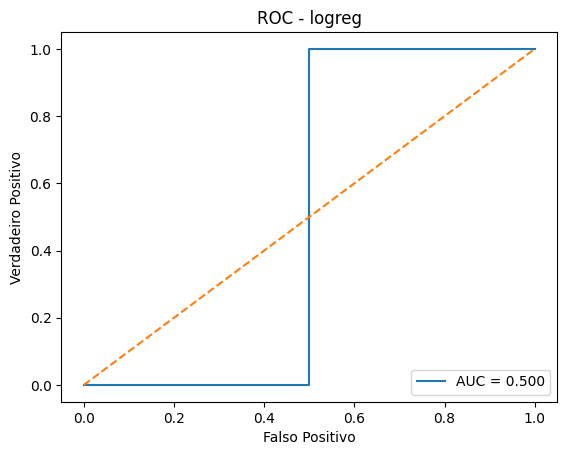

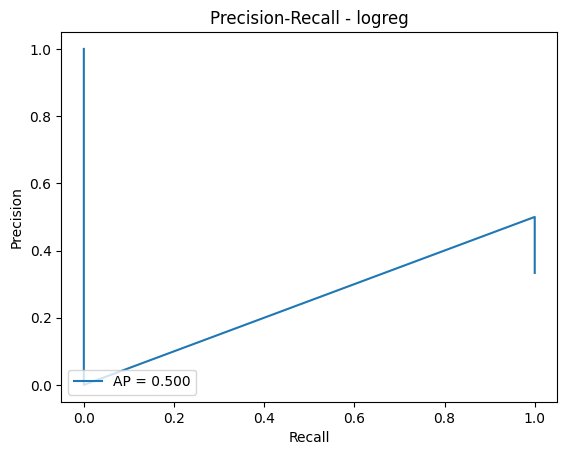

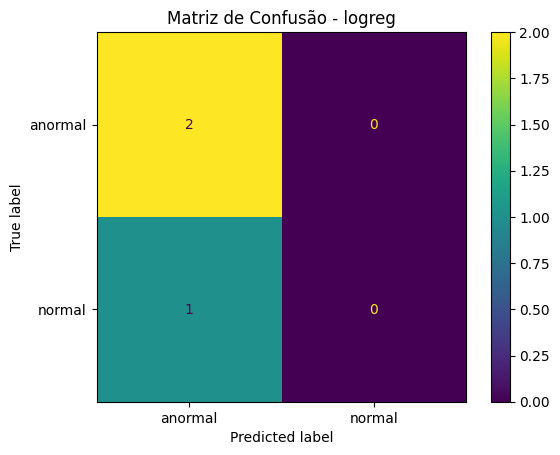


=== linsvc — Teste ===
Accuracy: 0.6667
F1: 0.0
              precision    recall  f1-score   support

     anormal       0.67      1.00      0.80         2
      normal       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



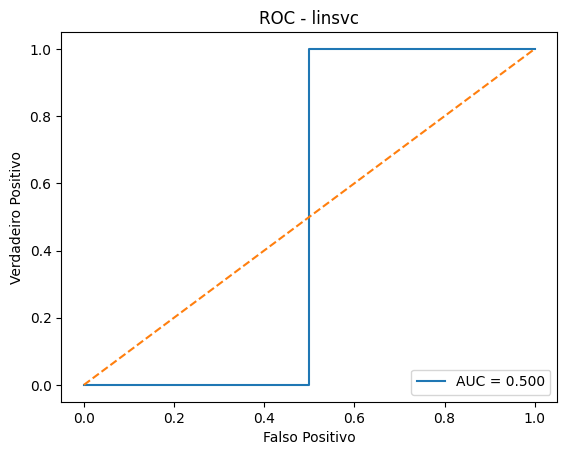

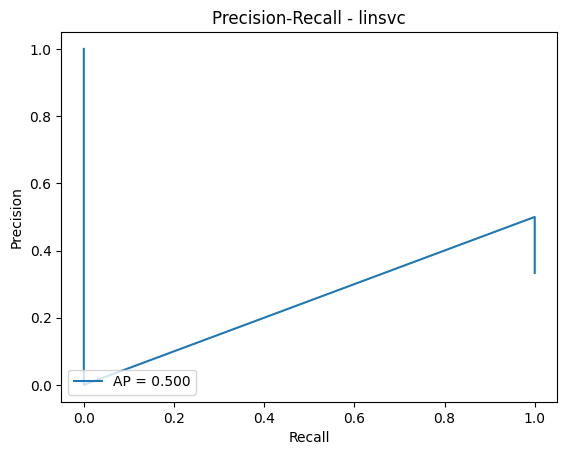

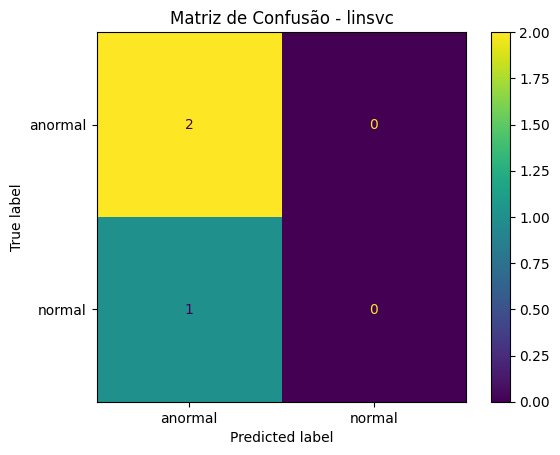


=== rf — Teste ===
Accuracy: 0.6667
F1: 0.0
              precision    recall  f1-score   support

     anormal       0.67      1.00      0.80         2
      normal       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



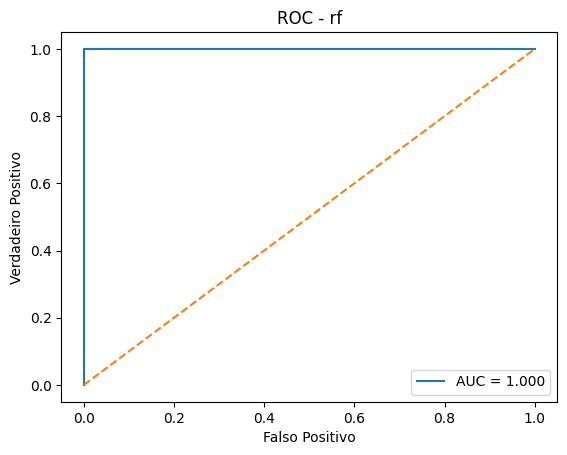

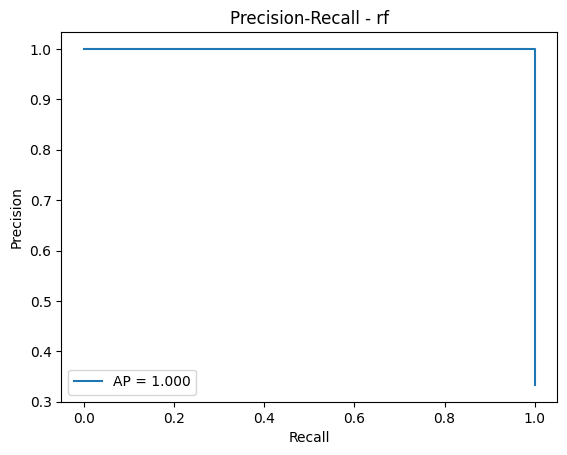

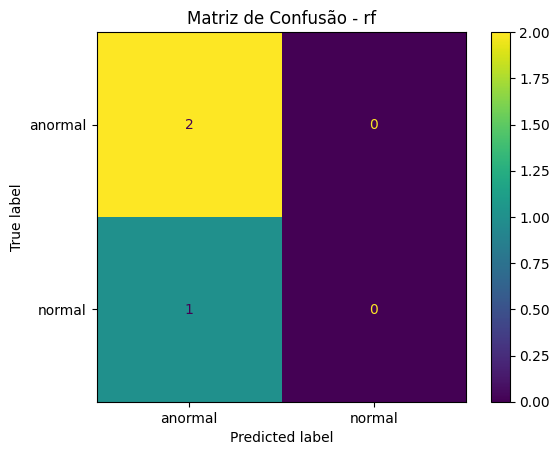


=== gboost — Teste ===
Accuracy: 0.3333
F1: 0.0
              precision    recall  f1-score   support

     anormal       0.50      0.50      0.50         2
      normal       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3



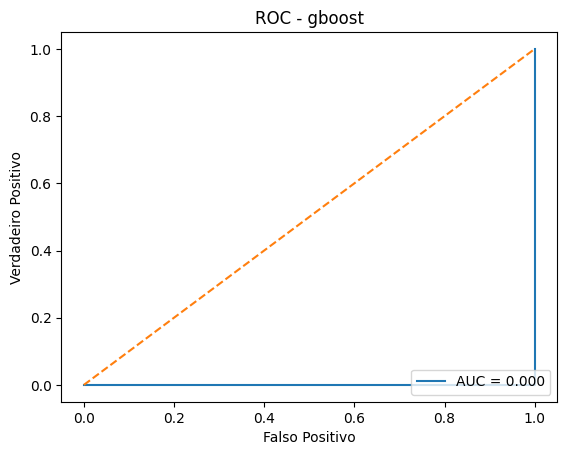

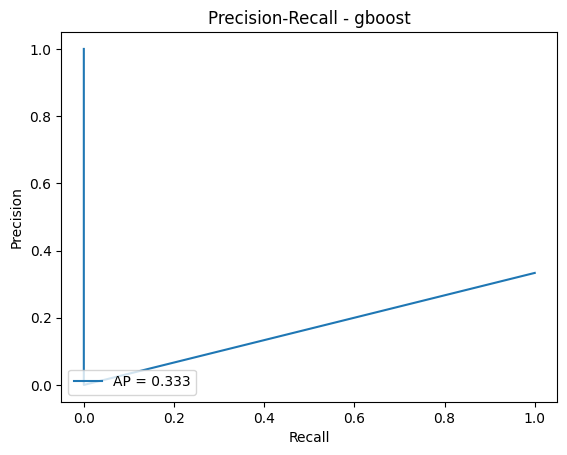

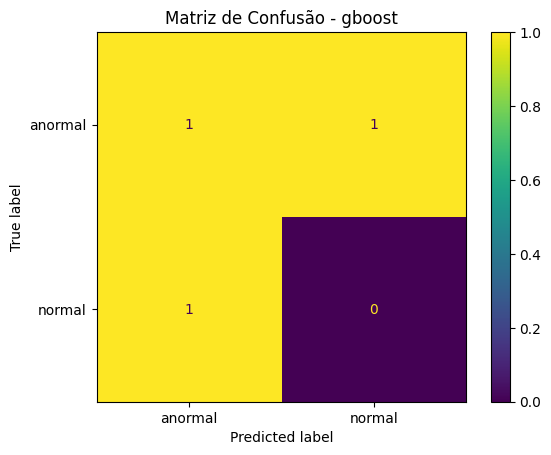


=== histgb — Teste ===
Accuracy: 0.6667
F1: 0.0
              precision    recall  f1-score   support

     anormal       0.67      1.00      0.80         2
      normal       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



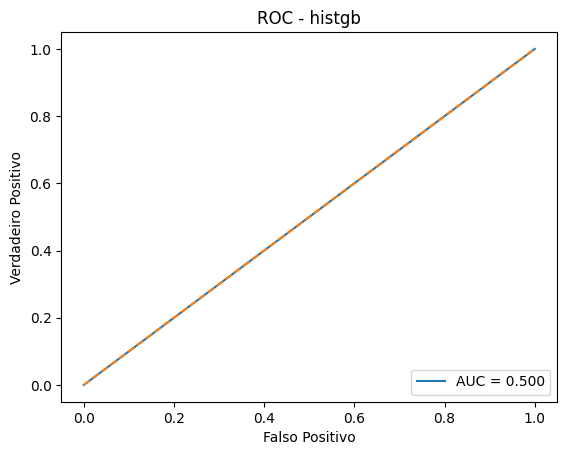

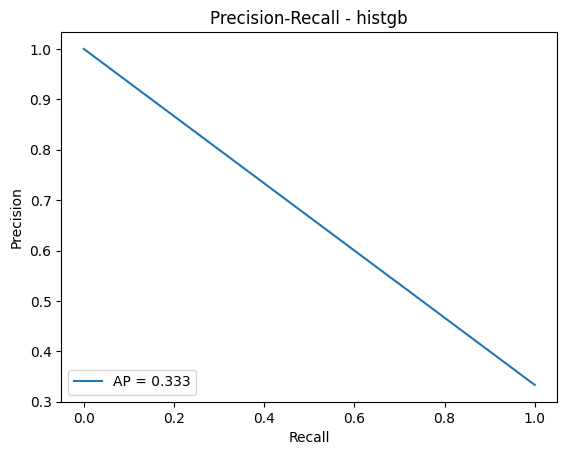

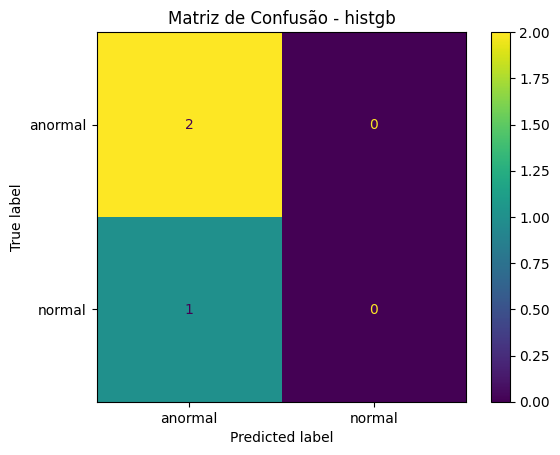

{'logreg_roc': '/content/logreg_roc.png',
 'logreg_pr': '/content/logreg_pr.png',
 'logreg_cm': '/content/logreg_cm.png',
 'linsvc_roc': '/content/linsvc_roc.png',
 'linsvc_pr': '/content/linsvc_pr.png',
 'linsvc_cm': '/content/linsvc_cm.png',
 'rf_roc': '/content/rf_roc.png',
 'rf_pr': '/content/rf_pr.png',
 'rf_cm': '/content/rf_cm.png',
 'gboost_roc': '/content/gboost_roc.png',
 'gboost_pr': '/content/gboost_pr.png',
 'gboost_cm': '/content/gboost_cm.png',
 'histgb_roc': '/content/histgb_roc.png',
 'histgb_pr': '/content/histgb_pr.png',
 'histgb_cm': '/content/histgb_cm.png'}

In [36]:
# === Avaliação no conjunto de teste + gráficos ===
def ensure_proba(clf, X):
    # retorna prob de classe positiva (1)
    if hasattr(clf, 'predict_proba'):
        return clf.predict_proba(X)[:, 1]
    elif hasattr(clf, 'decision_function'):
        s = clf.decision_function(X)
        # min-max para [0,1] (aproximação)
        s = (s - s.min()) / (s.max() - s.min() + 1e-8)
        return s
    else:
        # fallback: 0/1
        return clf.predict(X)

fig_paths = {}

for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = ensure_proba(model, X_test)

    print(f'\n=== {name} — Teste ===')
    print('Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('F1:', round(f1_score(y_test, y_pred), 4))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title(f'ROC - {name}')
    plt.legend(loc='lower right')
    p_roc = f'/content/{name}_roc.png'
    plt.savefig(p_roc, dpi=120, bbox_inches='tight')
    plt.show()
    fig_paths[f'{name}_roc'] = p_roc

    # PR
    p, r, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.figure()
    plt.plot(r, p, label=f'AP = {ap:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall - {name}')
    plt.legend(loc='lower left')
    p_pr = f'/content/{name}_pr.png'
    plt.savefig(p_pr, dpi=120, bbox_inches='tight')
    plt.show()
    fig_paths[f'{name}_pr'] = p_pr

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(values_format='d')
    plt.title(f'Matriz de Confusão - {name}')
    p_cm = f'/content/{name}_cm.png'
    plt.savefig(p_cm, dpi=120, bbox_inches='tight')
    plt.show()
    fig_paths[f'{name}_cm'] = p_cm

# Exibe caminhos das figuras (úteis para baixar se desejar)
fig_paths


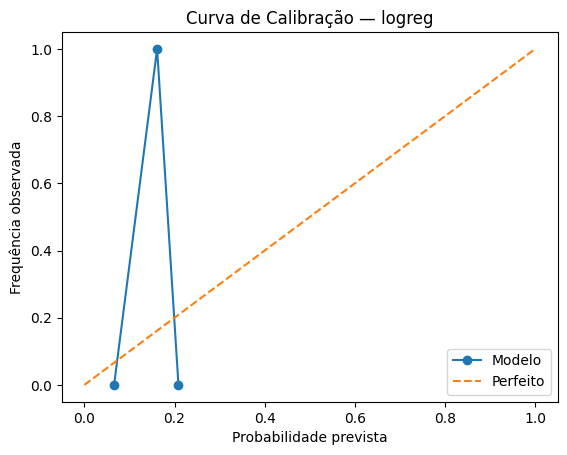

'/content/logreg_calibration.png'

In [37]:
# === Curva de Calibração do melhor modelo por F1-CV ===
best_name = res_df.iloc[0]['modelo']
best_model = best_models[best_name]
best_model.fit(X_train, y_train)
y_proba = (best_model.predict_proba(X_test)[:,1]
           if hasattr(best_model, 'predict_proba')
           else ensure_proba(best_model, X_test))

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
plt.plot([0,1],[0,1],'--', label='Perfeito')
plt.xlabel('Probabilidade prevista')
plt.ylabel('Frequência observada')
plt.title(f'Curva de Calibração — {best_name}')
plt.legend()
p_cal = f'/content/{best_name}_calibration.png'
plt.savefig(p_cal, dpi=120, bbox_inches='tight')
plt.show()

p_cal


In [38]:
# === Salva melhor modelo no Drive ===
OUT_DIR = Path('/content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/models')
OUT_DIR.mkdir(parents=True, exist_ok=True)
model_path = OUT_DIR / f'best_model_{best_name}.joblib'
joblib.dump(best_model, model_path)
print('Modelo salvo em:', model_path)


Modelo salvo em: /content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/models/best_model_logreg.joblib


In [39]:
# === Função utilitária para previsão em novos vídeos (poses) ===
def predict_from_pose_path(pose_path: str):
    seq = safe_load_pose(Path(pose_path))
    if seq is None:
        raise FileNotFoundError(f'Não foi possível carregar {pose_path}')
    feat = extract_features(seq).reshape(1,-1)
    proba = (best_model.predict_proba(feat)[:,1]
             if hasattr(best_model, 'predict_proba')
             else ensure_proba(best_model, feat))
    pred = (proba >= 0.5).astype(int)
    label = le.inverse_transform(pred)[0]
    return float(proba[0]), label

# Exemplo (edite o caminho abaixo para um arquivo real)
# predict_from_pose_path('/content/drive/MyDrive/Estudos/IA_CD/Modelo_Treino_Marcha/processed/poses/SEU_ID_poses.npy')
